In [285]:
import safety_gym
import gym
import numpy as np

In [309]:
from safety_gym.envs.engine import Engine

config = {
    'robot_base': 'xmls/point.xml',
    'task': 'push',
    'observation_flatten': False, 
    'observe_goal_lidar': True,
    'lidar_max_dist': 3,
    'lidar_num_bins': 16,
    'task': 'goal',
    'goal_size': .3,
    'goal_keepout': 0.305,
    'hazards_size': 0.2,
    'hazards_keepout': 0.18,
    'action_noise': 0.0
    
    
}

env2 = Engine(config)

In [310]:
from copy import deepcopy

#phs
stats = []
actions = []
lidars = []


o = env2.reset()
goal_pos = env2.goal_pos
print(o)
steps = 1000
a_list = np.array([[.5,.3], 
     [.5,-.5],
     [.5,.7],
     [-.5,-.3],
     [-.5,.7],
     [-1,1],
     [-1,.3], 
     [-1,-.5],
     [.5,-1],
     [.5,-.7],
     [1,.1],
     [0.2,.6],
     [0,-.6],
     [1,.1],
     [-.5,-1],])

a_ind = 0
use_rand_a = False

## cont actions
x = np.linspace(-20*np.pi, 20*np.pi, steps)
sin_as = np.expand_dims(np.sin(x), axis=1)
cos_as = np.expand_dims(np.cos(x), axis=1)
tri_as = np.concatenate((sin_as,cos_as), axis=1)
for i in range(steps): 
    # env2.render()
    # obs, _, _, _ = env2.step([.5/30,0])
    if (i)%5==0:
        a_ind=np.random.randint(len(a_list))
        #a_ind = 11
    if i%int(steps/5)==0:
        use_rand_a = not use_rand_a
    if use_rand_a:
        a = a_list[a_ind]
    else:
        a = tri_as[i]
    
    obs, _, done, _ = env2.step(a)  #a[a_ind])    
    if(done):
        print("DONE")
    stats.append([obs['velocimeter'], 
                  obs['accelerometer'], 
                  deepcopy(env2.world.sim.data.qpos), 
                  obs['gyro'], 
                  obs['magnetometer'],
                 ])
    lidars.append(obs['goal_lidar'])
    actions.append(a)   #a[a_ind])
    #print(env2.world.sim.data.qpos)
    #print(obs['velocimeter'], obs['accelerometer'])
print(obs)
#env2.close()

{'goal_lidar': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03699073, 0.37470451, 0.33771379, 0.        ,
       0.        ]), 'accelerometer': array([0.  , 0.  , 9.81]), 'velocimeter': array([0., 0., 0.]), 'gyro': array([0., 0., 0.]), 'magnetometer': array([-0.38199156, -0.32261811,  0.        ])}
DONE
{'goal_lidar': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'accelerometer': array([-1.52927137, -9.07713965,  9.81      ]), 'velocimeter': array([-0.67718091, -0.05947433,  0.        ]), 'gyro': array([ 0.        ,  0.        , -1.71208237]), 'magnetometer': array([-0.34417037, -0.36269375,  0.        ])}


In [305]:
stats = np.array(stats)
actions = np.array(actions)
#acc_ys = np.array(acc_ys)
#print(acc_ys)

(1000, 2)


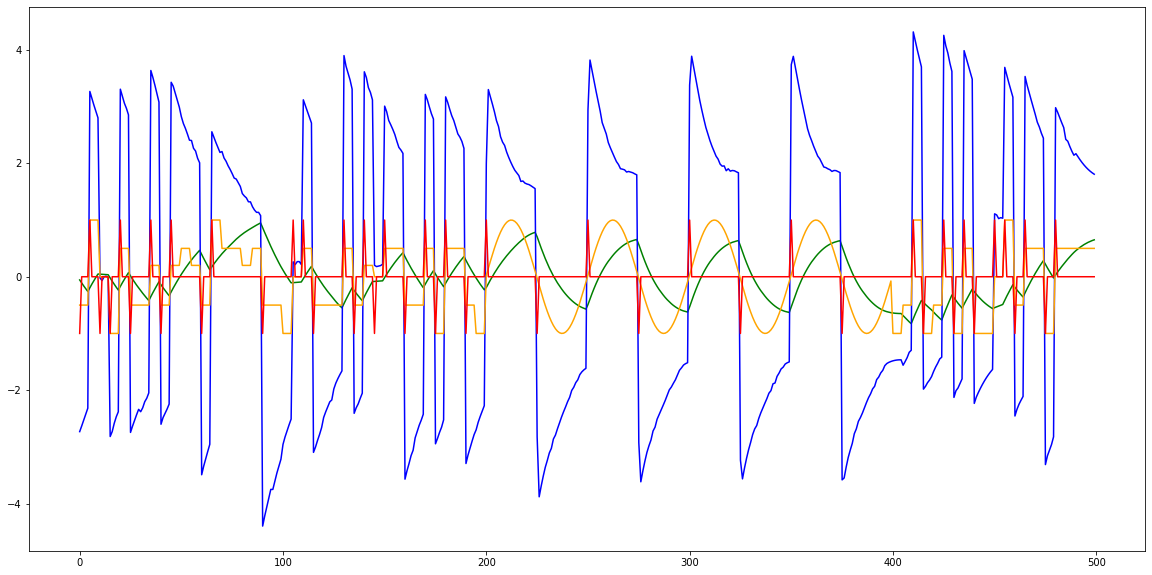

In [306]:
import matplotlib.pyplot as plt
from scipy import signal

plt_start = 0
plt_end = 500
print(actions.shape)

plt.figure(figsize=(20,10))

# x-vel and x-acc
plt.plot(np.arange(plt_end-plt_start), stats[plt_start:plt_end,0,0], color = 'green')    #x-vel
plt.plot(np.arange(plt_end-plt_start), stats[plt_start:plt_end,1,0], color = 'blue')  #x-acc
plt.plot(np.arange(plt_end-plt_start), actions[plt_start:plt_end,0], color='orange')   #x-act
acc_pred = np.zeros(shape=(plt_end-plt_start,))
a_last = 0
for i in range(plt_start, plt_end):
    if i>0:
        a_last = actions[i-1,0]
    a_cur = actions[i,0]
    if a_last==a_cur:
        acc_pred[i]=0
    else:
        if a_last<=0<=a_cur or a_cur <=0<= a_last:
            #pass
            acc_pred[i]=a_cur-a_last

acc_pred = np.where(acc_pred>0,1,acc_pred)
acc_pred = np.where(acc_pred<0,-1,acc_pred)
plt.plot(np.arange(plt_end-plt_start), acc_pred, color='red')   #x-acc spike prediction
#plt.plot(np.arange(len(stats)), stats[plt_start:plt_end,2,0])
#plt.plot(np.arange(len(stats)), stats[plt_start:plt_end,2,1])



IndexError: too many indices for array

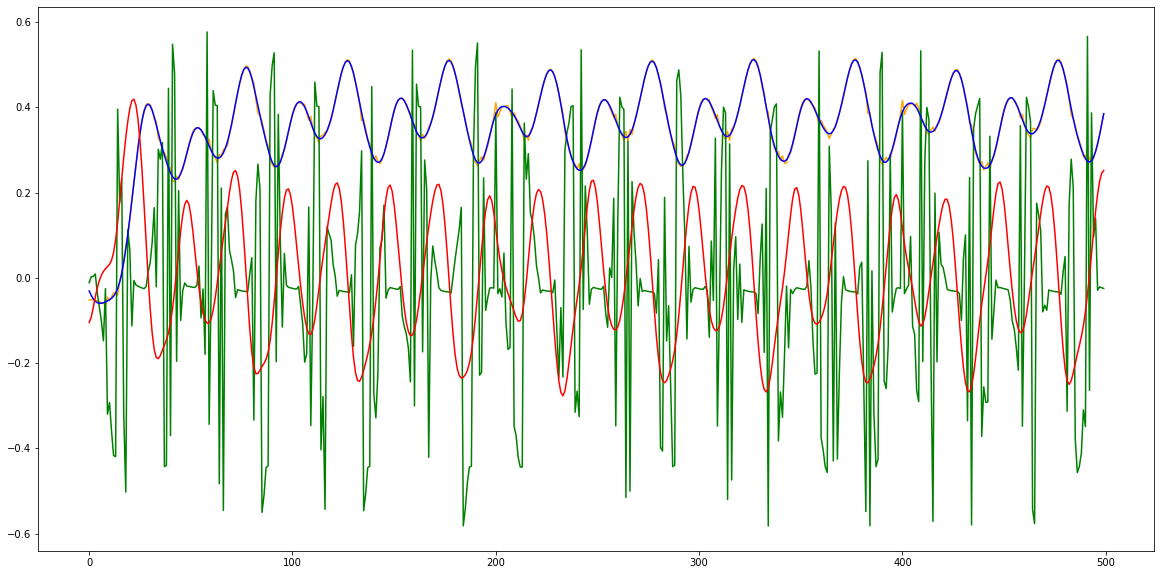

In [242]:
plt.figure(figsize=(20,10))

### smoothen
pad = np.zeros(shape=(12,5,3))
pad_ph = np.concatenate((pad,stats), axis=0)  #augment with zeros for padding of filter

b, a = signal.butter(3, 0.2)
v_y = signal.filtfilt(b, a, pad_ph[plt_start:plt_end+12,0,1])
acc_y = 10*np.gradient(v_y, 1)


# y-vel and y-acc
plt.plot(np.arange(plt_end-plt_start), stats[plt_start:plt_end,0,1], color='orange')   # y-vel
plt.plot(np.arange(plt_end-plt_start), stats[plt_start:plt_end,1,1]/30, color='green')# y-acc
plt.plot(np.arange(plt_end-plt_start), v_y[12:], color='blue')                         # filtered y-vel
plt.plot(np.arange(plt_end-plt_start), acc_y[12:], color='red')                        # np grad of filt. y-vel
plt.plot(np.arange(plt_end-plt_start), actions[plt_start:plt_end,1]/10, color='purple')#action steer


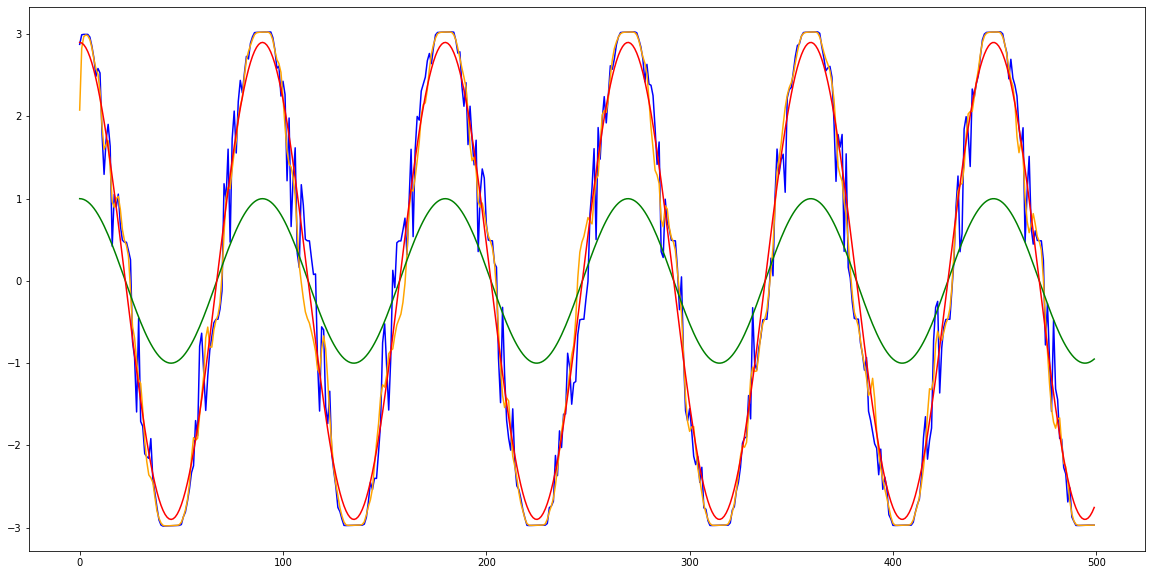

In [217]:
plt.figure(figsize=(20,10))

b_g, a_g = signal.butter(1, 0.4) #cheby1(5,1, 0.5)       # butterwort filter
g_z = signal.filtfilt(b_g, a_g, pad_ph[plt_start:plt_end+12,3,2])          
#_y = 50*np.gradient(v_y, 1)

plt.plot(np.arange(plt_end-plt_start), stats[plt_start:plt_end,3,2], color='blue')  #gyro z
#plt.plot(np.arange(plt_end-plt_start), np.sum(stats[:step, 4, :], axis=-1))        # magneto sum
g_np = np.gradient(stats[plt_start:plt_end, 4, 0])                                  # grad magneto x
#plt.plot(np.arange(plt_end-plt_start), g_np)                                       # grad magneto x 
#plt.plot(np.arange(plt_end-plt_start), stats[:step,4,1])                           # magneto y
plt.plot(np.arange(plt_end-plt_start), g_z[12:], color='orange')                         # filtered gyro z
plt.plot(np.arange(plt_end-plt_start), actions[plt_start:plt_end,-1], color='green')   #action steer
plt.plot(np.arange(plt_end-plt_start), 2.9*actions[plt_start:plt_end,-1], color='red')  



[3.         3.         0.00945235 0.08279395 0.07334161 3.
 3.         3.         3.         3.         3.         3.
 3.         3.         3.         3.        ]


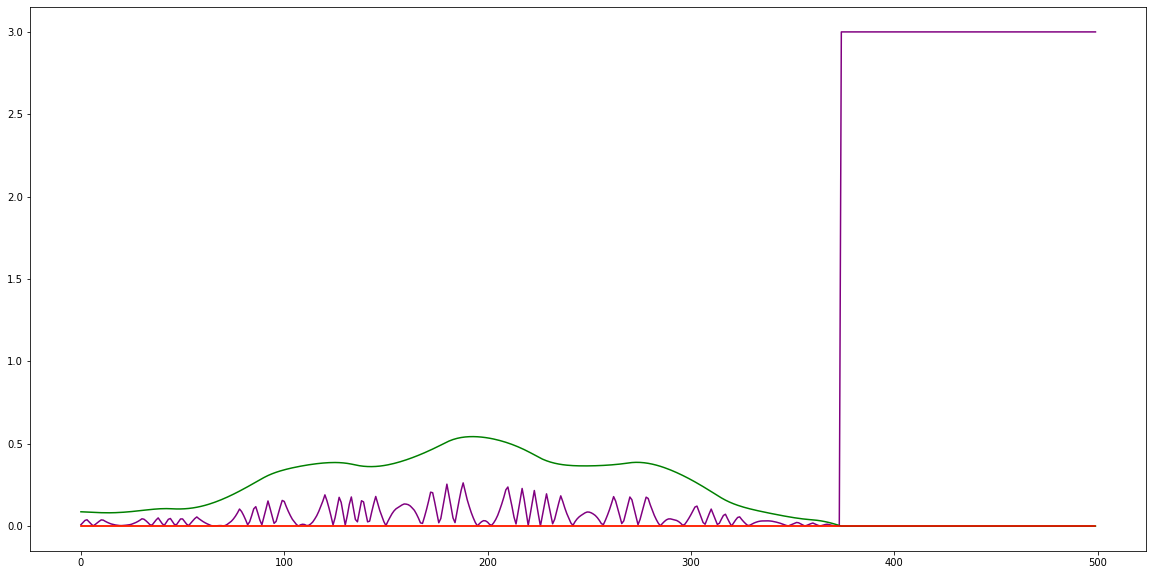

In [210]:
plt.figure(figsize=(20,10))

lidars_np = np.array(lidars)
g_lidar = np.mean(np.gradient(lidars_np, axis=1),axis=1)                               # grad magneto x
#print(np.argmin(lidars, axis=0))
#print(lidars_np[190])
lidars_nz = np.where(lidars_np==0, 3, lidars_np)
print(lidars_nz[7])
lidar_mins_nz = (np.min(lidars_nz, axis=1)[plt_start:plt_end])        #min values of goal lidar
lidar_mins = (np.min(lidars_np, axis=1)[plt_start:plt_end])        #min values of goal lidar
lidar_maxs = (np.max(lidars_np, axis=1)[plt_start:plt_end])             #max values of goal lidar
plt.plot(np.arange(plt_end-plt_start), lidar_mins_nz, color='purple')
plt.plot(np.arange(plt_end-plt_start), lidar_mins, color='orange')
plt.plot(np.arange(plt_end-plt_start), lidar_maxs, color='green')
plt.plot(np.arange(plt_end-plt_start), g_lidar[plt_start:plt_end], color='red')
#plt.plot(np.arange(plt_end-plt_start), g_z[12:], color='orange')                         # index of min range pos


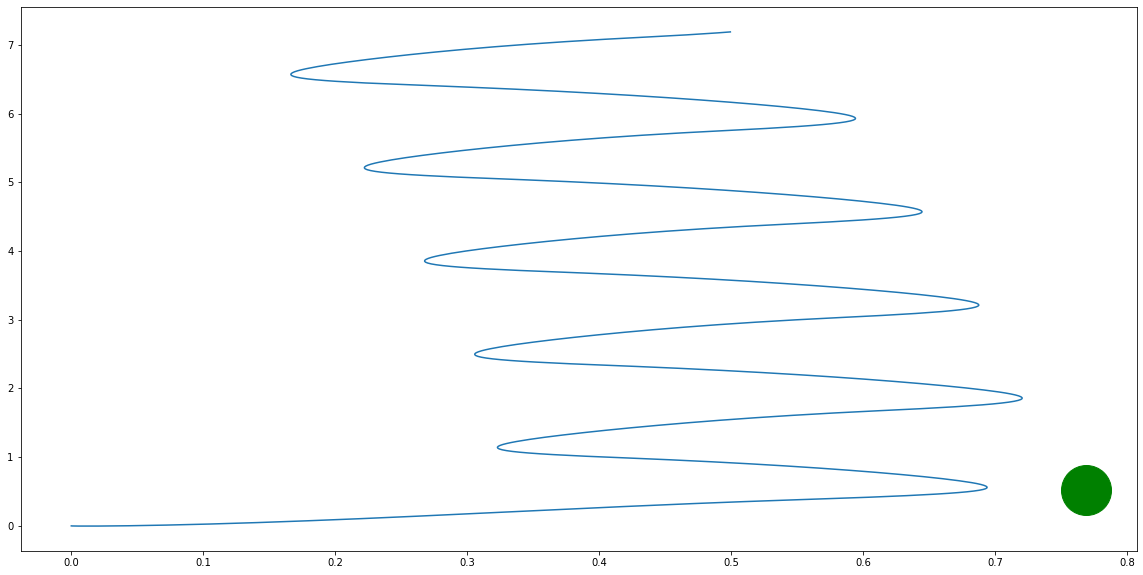

In [211]:
plt.figure(figsize=(20,10))

plt.plot(stats[plt_start:plt_end,2,0], stats[plt_start:plt_end,2,1])
plt.plot([goal_pos[0]], [goal_pos[1]],marker='o', markersize=50, color='green')

In [13]:
acc = []
acc.append(0)
for i in range(len(stats)): 
    if i != 0:
        acc.append((stats[i,0,0]-stats[i-1,0,0])*50)



In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(stats)), stats[:,0,0])
plt.plot(np.arange(len(stats)), stats[:,1,0])
plt.plot(np.arange(len(stats)), acc)

In [ ]:
env2.observation_space

In [ ]:
env2.reset()

In [ ]:
np.count_nonzero(env2.reset())

In [ ]:
env2.observe_com

In [ ]:
env2.observe_vases

In [ ]:
env2.obs()